In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd

sys.path.insert(1, '/scr/gmachi/prospection/K2/src')
from utils import deserialize, serialize, deserialize_model

In [3]:
import pandas as pd
dfGs_all = pd.read_csv("/scr/biggest/gmachi/datasets/celldive_lung/top_model_results_final/dfGs_all.csv")

## construct a dataset

In [4]:
def parse_df_list(row):
    row = row.split(" ")
    row = [r.strip() for r in row]
    row = [r.rstrip("]") for r in row]
    row = [r.lstrip("[]") for r in row]
    row = [float(r) for r in row if r not in ["[", "", "]"]]     
    return row

In [5]:
df_0 = dfGs_all[dfGs_all["class_member"] == 0]
# df_0 = dfGs_all[dfGs_all["salbin"] == "non-salient"]
df_1sal = dfGs_all[dfGs_all["salbin"] == "salient"]
# df_filtered = pd.concat([df_0, df_1sal])
# df_filtered = df_filtered.sample(frac=1)

In [6]:
df_1sal.shape, df_0.shape

((164499, 11), (762207, 11))

In [7]:
n = df_1sal.shape[0]
n

164499

In [8]:
df_sample0 = df_0.sample(n=n, replace=False, random_state=1)
df_sample1 = df_1sal.sample(n=n, replace=False, random_state=1)

In [9]:
# df_filtered = pd.concat([df_0, df_1sal])
df_filtered = pd.concat([df_sample0, df_sample1])
df_filtered = df_filtered.sample(frac=1)
df_filtered.shape

(328998, 11)

## get train test split

In [10]:
# df_test = pd.concat([df_sample0, df_sample1])
# df_test = df_filtered.sample(frac=0.2, random_state=1)


In [11]:
# df_test.shape

In [87]:
df_filtered.shape

(328998, 11)

In [88]:
X = df_filtered.loc[:, "raw"]
X = X.apply(lambda x: parse_df_list(x))
X_raw = np.vstack(list(X.values))

In [89]:
# from sklearn.preprocessing import FunctionTransformer
# transformer = FunctionTransformer(np.log1p, validate=True)
# X = transformer.transform(X)

In [90]:
y_base = list(df_filtered.loc[:, "salient"].values)
print(y_base[0:20])
y_raw = np.array([0 if np.isnan(i) else 1 for i in y_base])
print(y_raw[0:20])

[4.0, 5.0, nan, nan, 2.0, 11.0, 5.0, nan, nan, 6.0, nan, nan, 7.0, nan, nan, 5.0, 5.0, nan, nan, nan]
[1 1 0 0 1 1 1 0 0 1 0 0 1 0 0 1 1 0 0 0]


In [91]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

X, Xt, y, yt = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42) 

scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
Xt = scaler.transform(Xt)

In [92]:
print(X.shape, y.shape)
print(Xt.shape, yt.shape)

(263198, 34) (263198,)
(65800, 34) (65800,)


In [93]:
print("class-1:",np.sum(y), np.sum(y) / y.shape[0])
print("class-0:",(y.shape[0] - np.sum(y)), (y.shape[0] - np.sum(y)) / y.shape[0])

class-1: 131717 0.5004483316742528
class-0: 131481 0.49955166832574716


In [94]:
# df_test = df_test.sample(frac=1)

# Xt = df_test.loc[:, "raw"]
# Xt = Xt.apply(lambda x: parse_df_list(x))
# Xt = np.vstack(list(Xt.values))

In [95]:
Xt.shape

(65800, 34)

In [96]:
# Xt = transformer.transform(Xt)
# Xt = scaler.transform(Xt)

In [97]:
# yt = list(df_test.loc[:, "salient"].values)
# print(yt[0:20])
# yt = np.array([0 if np.isnan(i) else 1 for i in yt])
# print(yt[0:20])

In [98]:
np.sum(yt), len(yt)

(32782, 65800)

In [99]:
G_ex = deserialize("/scr/biggest/gmachi/datasets/celldive_lung/for_ml/for_prospect_final/S3.obj")
prot_feats = list(G_ex.nodes[0]["biomarker_expression"].keys())
morph_feats = ['AREA_CELL', 'ECCENTRICITY', 'MAJORAXISLENGTH', 'MINORAXISLENGTH', 'PERIMETER']
all_feats = prot_feats + morph_feats
print(all_feats)

['AKT', 'AMPHIREGULIN', 'BETA_CATENIN', 'BETA_TUBULIN', 'CA9', 'CK5', 'CK7', 'CMET', 'CYCLIN_B', 'ECAD', 'EGFR', 'EGFR_PY1068', 'ERK', 'ERK1_2_PT202_PY204', 'HER2', 'IGF1R', 'NAKATPASE', 'P21', 'P4EBP1', 'PANKERATIN', 'PGSK3BETA', 'PHISTONEH3', 'PHOSPHOTYROSINE', 'PTEN', 'RRM1', 'S6', 'STAT3', 'STAT3_PY705', 'VGFR2', 'AREA_CELL', 'ECCENTRICITY', 'MAJORAXISLENGTH', 'MINORAXISLENGTH', 'PERIMETER']


In [100]:
# idxs = [all_feats.index(i) for i in ['BETA_TUBULIN', "CK5", 'CK7', 'P4EBP1', 'PANKERATIN', 'PHOSPHOTYROSINE']]
# idxs

## Logistic Regression

We can prune X to only important features

In [101]:
# Xp = X[:, idxs]
# Xp.shape

In [102]:
from sklearn.linear_model import LogisticRegression
# clf = LogisticRegression(penalty='l2', solver="saga", random_state=6, max_iter=10000, tol=1e-6) #max_iter=10000)
clf_all = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, random_state=6, max_iter=10000, tol=1e-6) #max_iter=10000)
# clf = LogisticRegression(solver='newton-cholesky', random_state=1, max_iter=10000)
# clf.fit(X,y)
clf_all.fit(X,y)

LogisticRegression(l1_ratio=0.5, max_iter=10000, penalty='elasticnet',
                   random_state=6, solver='saga', tol=1e-06)

In [103]:
clf_all.score(X, y)

0.7147622702300169

- right before: 0.7145647003396682

In [104]:
clf_all.score(Xt, yt)

0.7120364741641337

- right before: 0.7130547112462006

In [105]:
b = np.array(clf_all.coef_[0]) # importance weights
print(b)

[-4.06998223 -2.17908522 -1.14952774 -0.74589257  3.04445546 -0.79850945
  0.83661758 -1.99892079 -1.77256555  1.76071844  5.10472578 -1.25402978
 15.91075116 -9.42511684  2.823387   -4.52640292  0.06962107 -0.69394813
  1.59743389 -3.7126305  -1.20342488  2.39525229 -0.95889986 -2.54673439
  0.62055418  2.50766612 -3.71582889  4.0036271  -5.31356437  1.24809998
 -0.10663875  4.62009655  1.09094867 -4.23965457]


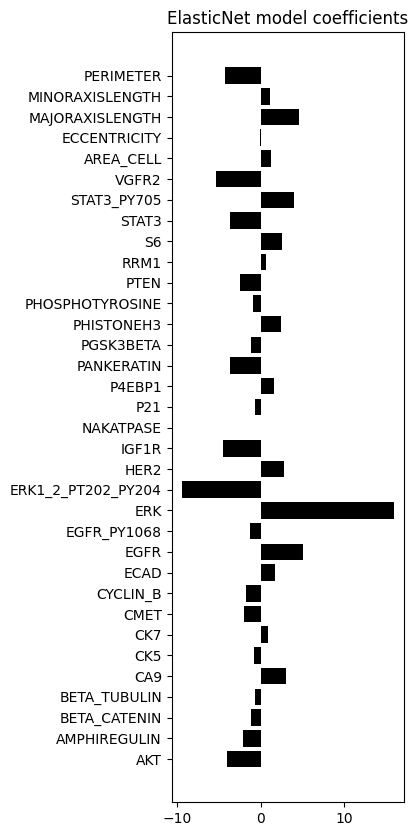

In [106]:
import matplotlib.pyplot as plt
plt.figure(figsize=(3, 10))

b = np.array(clf_all.coef_[0]) # importance weights
plt.barh(all_feats, b, color="k")


# plt.barh(all_feats, b, color="k")
plt.title("ElasticNet model coefficients")
plt.show()

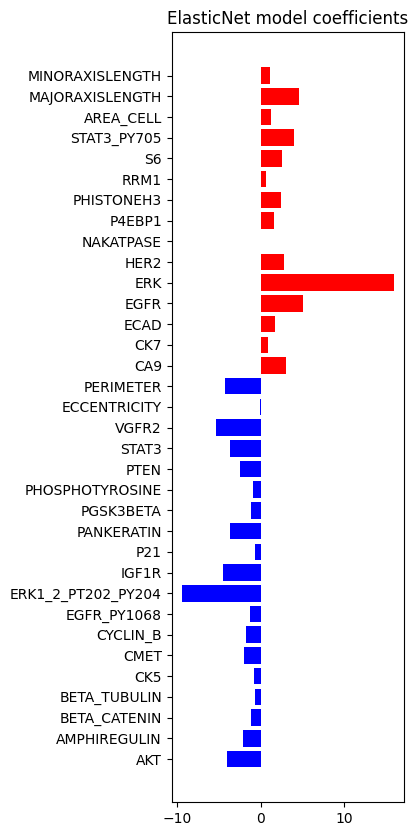

In [107]:
import matplotlib.pyplot as plt
plt.figure(figsize=(3, 10))
mask0 = b <= 0
mask1 = b > 0
feats0 = [all_feats[i] for i, x in enumerate(mask0) if x == True]
feats1 = [all_feats[i] for i, x in enumerate(mask1) if x == True]

plt.barh(feats0, b[mask0], color='blue')
plt.barh(feats1, b[mask1], color='red')

# plt.barh(all_feats, b, color="k")
plt.title("ElasticNet model coefficients")
plt.show()

In [108]:
scores = dict(zip(all_feats, b))
list({k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse=True)}.items())[0:5]

[('ERK', 15.910751155365217),
 ('EGFR', 5.104725776666176),
 ('MAJORAXISLENGTH', 4.62009655028318),
 ('STAT3_PY705', 4.0036271018193945),
 ('CA9', 3.0444554598850844)]

In [109]:
sorted_scores = list({k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse=True)}.items())
top_positives_threshold_mass(sorted_scores, threshold=0.75)

[('ERK', 15.910751155365217),
 ('EGFR', 5.104725776666176),
 ('MAJORAXISLENGTH', 4.62009655028318),
 ('STAT3_PY705', 4.0036271018193945),
 ('CA9', 3.0444554598850844),
 ('HER2', 2.8233869958862488),
 ('S6', 2.5076661200789467)]

In [187]:
from sklearn import metrics
# fpr, tpr, thresholds = metrics.roc_curve(y, clf.predict_proba(X)[:,1])
fpr, tpr, thresholds = metrics.roc_curve(yt, clf_all.predict_proba(Xt)[:,1])
metrics.auc(fpr, tpr)

0.779946752083371

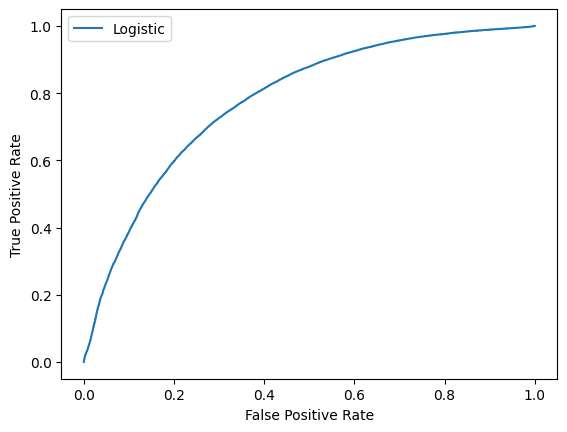

In [188]:
# plot the roc curve for the model
plt.figure()
plt.plot(fpr, tpr, label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.show()

In [189]:
metrics.balanced_accuracy_score(yt, clf_all.predict(Xt))

0.7131141323225845

In [190]:
metrics.balanced_accuracy_score(yt, clf_all.predict(Xt), adjusted=True)

0.42622826464516894

In [191]:
# from sklearn.model_selection import cross_val_score
# scores = cross_val_score(clf, X, y, cv=5)
# print(scores)

## try onevsrest

In [27]:
feat2idx_dict = {feat: i for i,feat in enumerate(all_feats)}

In [28]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

Let's up the number of train split examples so the model can properly learn the important features of each salient group

In [33]:
# y_multi = list(df_filtered.loc[:, "salient"].values)
# print(y_multi[0:20])
# y_multi = np.array([0 if np.isnan(i) else int(i) for i in y_multi])
y_multi = np.array([-1 if np.isnan(i) else int(i) for i in y_base])
print(y_multi[0:20])

[ 4  5 -1 -1  2 11  5 -1 -1  6 -1 -1  7 -1 -1  5  5 -1 -1 -1]


In [34]:
X, Xt, y_multi, yt_multi = train_test_split(X_raw, y_multi, test_size=0.1, random_state=42) 

scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
Xt = scaler.transform(Xt)

In [35]:
clf = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, random_state=6, max_iter=10000, tol=1e-6) #max_iter=10000)
clf = OneVsRestClassifier(clf).fit(X, y_multi)

In [36]:
clf.score(X, y_multi)

0.617994717964998

- right before: 0.6183966119325358
- used to have score of 0.5925938318365744, 0.5385387528942543

In [251]:
# yt_multi = list(df_test.loc[:, "salient"].values)
# print(yt[0:20])
# yt_multi = np.array([-1 if np.isnan(i) else int(i) for i in yt_multi])
# print(yt_multi[0:20])

In [37]:
clf.score(Xt, yt_multi)

0.6200607902735562

- right before: 0.6175379939209726

In [253]:
clf.estimators_

[LogisticRegression(l1_ratio=0.5, max_iter=10000, penalty='elasticnet',
                    random_state=6, solver='saga', tol=1e-06),
 LogisticRegression(l1_ratio=0.5, max_iter=10000, penalty='elasticnet',
                    random_state=6, solver='saga', tol=1e-06),
 LogisticRegression(l1_ratio=0.5, max_iter=10000, penalty='elasticnet',
                    random_state=6, solver='saga', tol=1e-06),
 LogisticRegression(l1_ratio=0.5, max_iter=10000, penalty='elasticnet',
                    random_state=6, solver='saga', tol=1e-06),
 LogisticRegression(l1_ratio=0.5, max_iter=10000, penalty='elasticnet',
                    random_state=6, solver='saga', tol=1e-06),
 LogisticRegression(l1_ratio=0.5, max_iter=10000, penalty='elasticnet',
                    random_state=6, solver='saga', tol=1e-06),
 LogisticRegression(l1_ratio=0.5, max_iter=10000, penalty='elasticnet',
                    random_state=6, solver='saga', tol=1e-06),
 LogisticRegression(l1_ratio=0.5, max_iter=10000, penal

In [38]:
clf.classes_

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [110]:
import utils
utils.serialize(clf, "/scr/gmachi/prospection/K2/notebooks/spatial-bio/elasticnet_model_2-13.obj")

In [44]:
import numpy as np

def top_positives_threshold_mass(vector, threshold=0.9):
    """
    Select the top positive values that contribute to the given probability threshold
    of the total positive mass, while preserving associated string labels.

    Parameters:
    - vector (list of tuples): List of (label, value) pairs.
    - threshold (float): Fraction of total positive mass to retain (default is 0.9).

    Returns:
    - list of tuples: The top (label, value) pairs contributing to the given mass threshold.
    """
    # Convert input to NumPy array for easy processing
    labels, values = zip(*vector)  # Separate labels and values
    values = np.array(values)      # Convert values to a NumPy array

    # Filter only positive values and corresponding labels
    positive_mask = values > 0
    positives = values[positive_mask]
    positive_labels = np.array(labels)[positive_mask]

    if positives.size == 0:
        return []  # Return empty list if no positive values
    
    # Sort indices by descending values
    sorted_indices = np.argsort(-positives)  # Negative sign for descending order
    sorted_positives = positives[sorted_indices]
    sorted_labels = positive_labels[sorted_indices]

    # Compute cumulative sum
    cumsum = np.cumsum(sorted_positives)

    # Compute the total sum of positive values
    total_positive_mass = cumsum[-1]

    # Find the index where cumulative sum exceeds the specified mass threshold
    cutoff_mass = threshold * total_positive_mass
    cutoff_index = np.searchsorted(cumsum, cutoff_mass, side='right')

    # Return the top (label, value) pairs contributing to the given mass threshold
    return list(zip(sorted_labels[:cutoff_index + 1], sorted_positives[:cutoff_index + 1]))


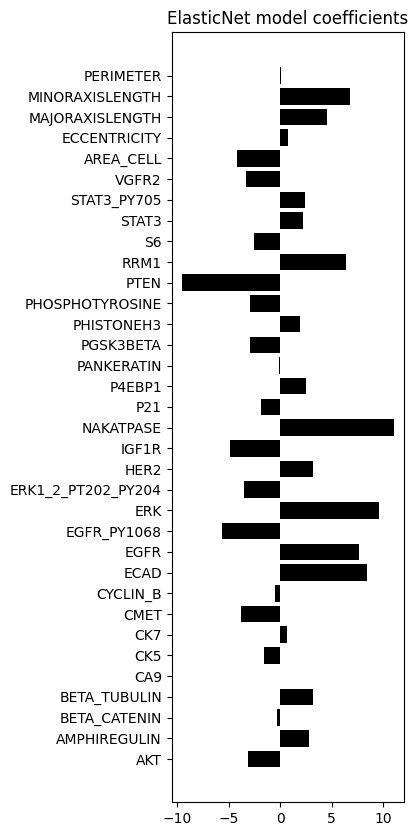

In [58]:
import matplotlib.pyplot as plt
plt.figure(figsize=(3, 10))

# concept 0
# b = clf.estimators_[0].coef_[0] # importance weights
b = clf.estimators_[1].coef_[0] # importance weights
plt.barh(all_feats, b, color="k")

# plt.barh(all_feats, b, color="k")
plt.title("ElasticNet model coefficients")
plt.show()

In [59]:
scores = dict(zip(all_feats, b))
list({k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse=True)}.items())[0:5]


[('NAKATPASE', 11.002236950058245),
 ('ERK', 9.571100425046513),
 ('ECAD', 8.425057124558052),
 ('EGFR', 7.609956362515509),
 ('MINORAXISLENGTH', 6.757945447949965)]

In [60]:
sorted_scores = list({k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse=True)}.items())
top_positives_threshold_mass(sorted_scores, threshold=0.75)

[('NAKATPASE', 11.002236950058245),
 ('ERK', 9.571100425046513),
 ('ECAD', 8.425057124558052),
 ('EGFR', 7.609956362515509),
 ('MINORAXISLENGTH', 6.757945447949965),
 ('RRM1', 6.393502161537415),
 ('MAJORAXISLENGTH', 4.5729348129750464),
 ('BETA_TUBULIN', 3.2114748515995157)]

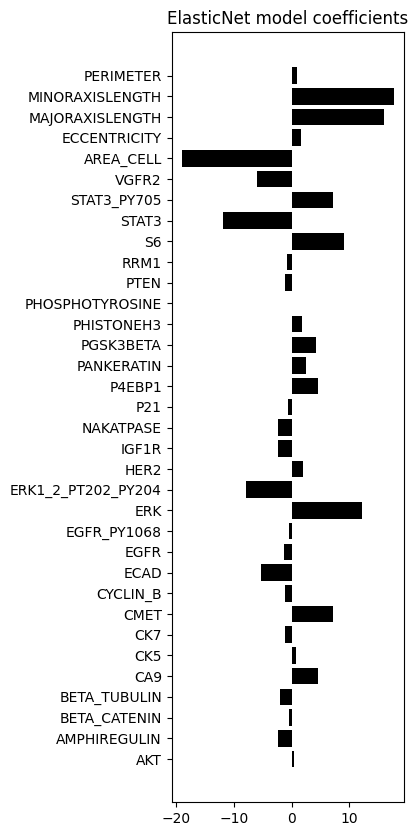

In [61]:
import matplotlib.pyplot as plt
plt.figure(figsize=(3, 10))

# concept 2
# b = clf.estimators_[1].coef_[0] # importance weights
b = clf.estimators_[3].coef_[0] # importance weights

plt.barh(all_feats, b, color="k")

# plt.barh(all_feats, b, color="k")
plt.title("ElasticNet model coefficients")
plt.show()

In [62]:
scores = dict(zip(all_feats, b))
list({k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse=True)}.items())[0:5]

[('MINORAXISLENGTH', 17.621188191223432),
 ('MAJORAXISLENGTH', 15.90319531239315),
 ('ERK', 12.165112596192843),
 ('S6', 9.11434265453015),
 ('STAT3_PY705', 7.22877508436714)]

In [63]:
sorted_scores = list({k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse=True)}.items())
top_positives_threshold_mass(sorted_scores, threshold=0.75)

[('MINORAXISLENGTH', 17.621188191223432),
 ('MAJORAXISLENGTH', 15.90319531239315),
 ('ERK', 12.165112596192843),
 ('S6', 9.11434265453015),
 ('STAT3_PY705', 7.22877508436714),
 ('CMET', 7.166258145003224),
 ('CA9', 4.5370322881040615)]

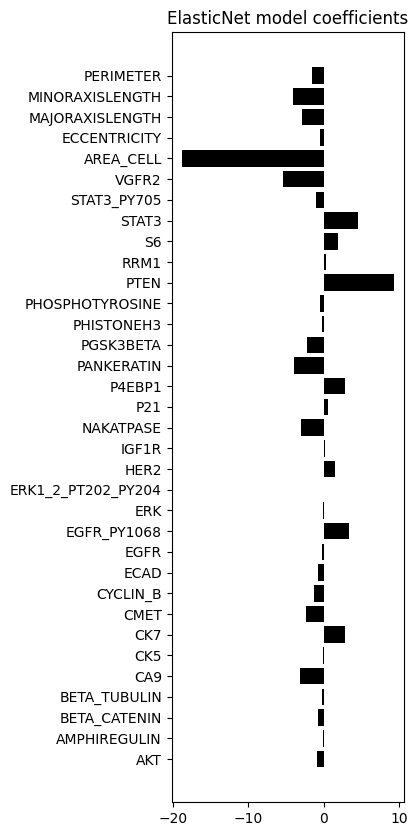

In [74]:
import matplotlib.pyplot as plt
plt.figure(figsize=(3, 10))

# concept 4
# b = clf.estimators_[3].coef_[0] # importance weights
b = clf.estimators_[5].coef_[0] # importance weights
plt.barh(all_feats, b, color="k")

# plt.barh(all_feats, b, color="k")
plt.title("ElasticNet model coefficients")
plt.show()

In [75]:
scores = dict(zip(all_feats, b))
list({k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse=True)}.items())[0:5]

[('PTEN', 9.280332717467271),
 ('STAT3', 4.619957840341633),
 ('EGFR_PY1068', 3.3729046267752585),
 ('CK7', 2.884037979226238),
 ('P4EBP1', 2.8629207297835926)]

In [76]:
sorted_scores = list({k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse=True)}.items())
top_positives_threshold_mass(sorted_scores, threshold=0.75)

[('PTEN', 9.280332717467271),
 ('STAT3', 4.619957840341633),
 ('EGFR_PY1068', 3.3729046267752585),
 ('CK7', 2.884037979226238),
 ('P4EBP1', 2.8629207297835926)]

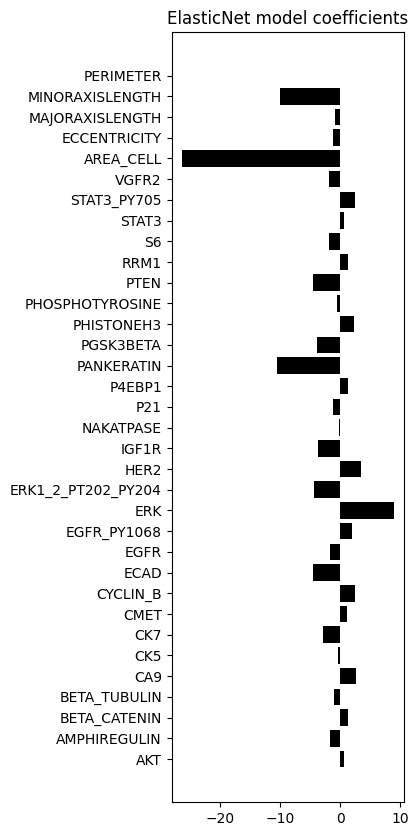

In [77]:
import matplotlib.pyplot as plt
plt.figure(figsize=(3, 10))

# concept 5
# b = clf.estimators_[5].coef_[0] # importance weights
b = clf.estimators_[6].coef_[0] # importance weights
plt.barh(all_feats, b, color="k")

# plt.barh(all_feats, b, color="k")
plt.title("ElasticNet model coefficients")
plt.show()

In [78]:
scores = dict(zip(all_feats, b))
list({k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse=True)}.items())[0:5]

[('ERK', 8.860655058134768),
 ('HER2', 3.5366337081573587),
 ('CA9', 2.586429554239417),
 ('CYCLIN_B', 2.5258923253502656),
 ('STAT3_PY705', 2.388823657413002)]

In [79]:
sorted_scores = list({k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse=True)}.items())
top_positives_threshold_mass(sorted_scores, threshold=0.75)

[('ERK', 8.860655058134768),
 ('HER2', 3.5366337081573587),
 ('CA9', 2.586429554239417),
 ('CYCLIN_B', 2.5258923253502656),
 ('STAT3_PY705', 2.388823657413002),
 ('PHISTONEH3', 2.3705295888194455),
 ('EGFR_PY1068', 2.0196232749500425)]

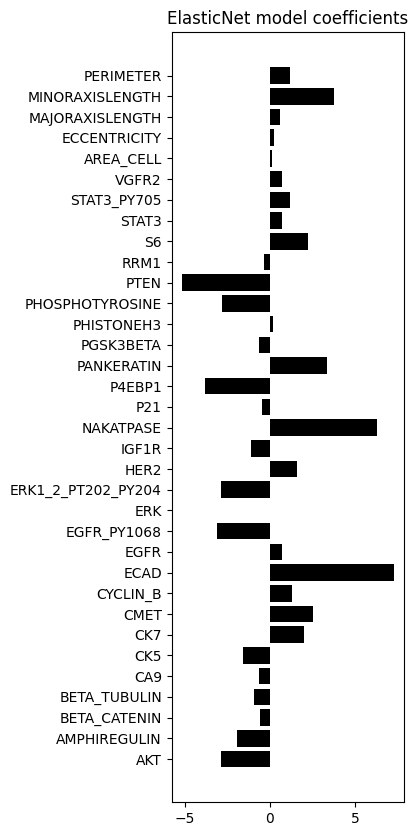

In [80]:
import matplotlib.pyplot as plt
plt.figure(figsize=(3, 10))

# concept 6
# b = clf.estimators_[7].coef_[0] # importance weights
b = clf.estimators_[7].coef_[0] # importance weights
plt.barh(all_feats, b, color="k")

# plt.barh(all_feats, b, color="k")
plt.title("ElasticNet model coefficients")
plt.show()

In [81]:
scores = dict(zip(all_feats, b))
list({k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse=True)}.items())[0:5]

[('ECAD', 7.250364731334376),
 ('NAKATPASE', 6.270181240844092),
 ('MINORAXISLENGTH', 3.7609728088256147),
 ('PANKERATIN', 3.3648529880856346),
 ('CMET', 2.5023660150823637)]

In [82]:
sorted_scores = list({k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse=True)}.items())
top_positives_threshold_mass(sorted_scores, threshold=0.75)

[('ECAD', 7.250364731334376),
 ('NAKATPASE', 6.270181240844092),
 ('MINORAXISLENGTH', 3.7609728088256147),
 ('PANKERATIN', 3.3648529880856346),
 ('CMET', 2.5023660150823637),
 ('S6', 2.2553532464076045),
 ('CK7', 2.003013279237964)]

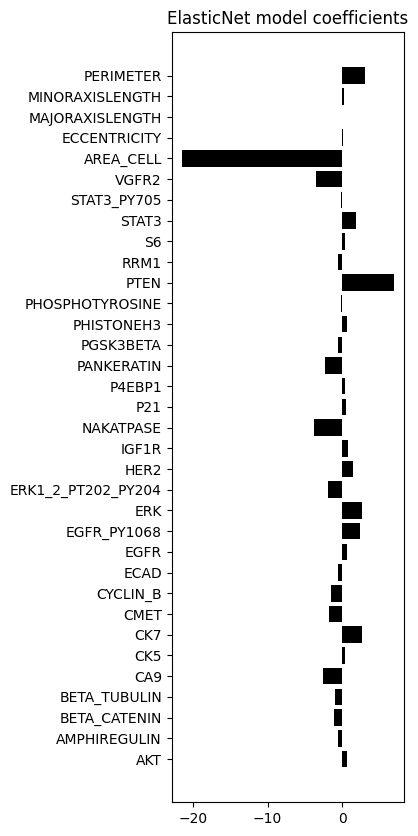

In [83]:
import matplotlib.pyplot as plt
plt.figure(figsize=(3, 10))

# concept 7
# b = clf.estimators_[7].coef_[0] # importance weights
b = clf.estimators_[8].coef_[0] # importance weights
plt.barh(all_feats, b, color="k")

# plt.barh(all_feats, b, color="k")
plt.title("ElasticNet model coefficients")
plt.show()

In [84]:
scores = dict(zip(all_feats, b))
list({k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse=True)}.items())[0:5]

[('PTEN', 6.829910183918072),
 ('PERIMETER', 3.052496750730959),
 ('CK7', 2.5836317333016487),
 ('ERK', 2.557861566276738),
 ('EGFR_PY1068', 2.313028816466847)]

In [85]:
sorted_scores = list({k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse=True)}.items())
top_positives_threshold_mass(sorted_scores, threshold=0.75)

[('PTEN', 6.829910183918072),
 ('PERIMETER', 3.052496750730959),
 ('CK7', 2.5836317333016487),
 ('ERK', 2.557861566276738),
 ('EGFR_PY1068', 2.313028816466847),
 ('STAT3', 1.7748335507943889)]

## Try XGBoost

In [220]:
import xgboost as xgb
xg = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

In [221]:
X, Xt, y, yt = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42) 

scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
Xt = scaler.transform(Xt)

In [222]:
xg.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [223]:
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
y_pred = xg.predict(X)
score = accuracy_score(y, y_pred)
print(score)

0.9707634556493591


In [224]:
y_pred = xg.predict(Xt)
score = accuracy_score(yt, y_pred)

print(xg.score(Xt, yt))
print(score)

0.9611702127659575
0.9611702127659575


In [226]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(yt, xg.predict_proba(Xt)[:,1])
metrics.auc(fpr, tpr)

0.9925512772569732

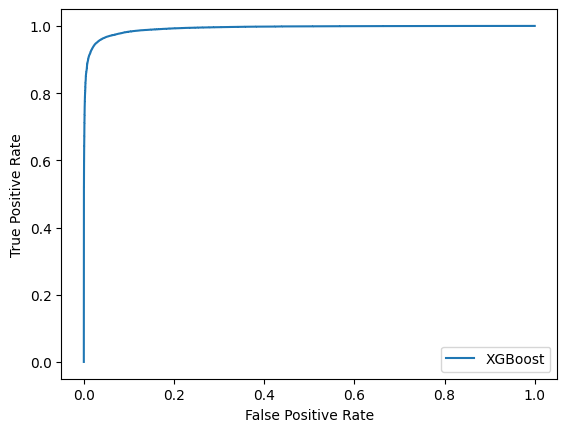

In [227]:
# plot the roc curve for the model
plt.figure()
plt.plot(fpr, tpr, label='XGBoost')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.show()

In [228]:
metrics.balanced_accuracy_score(y, xg.predict(X))

0.9707721996931498

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 1000x1000 with 0 Axes>

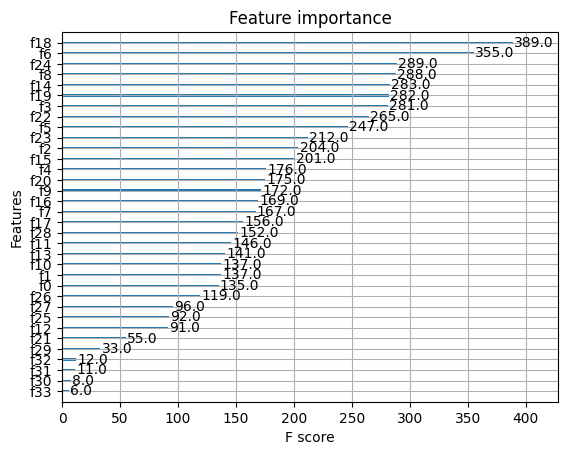

In [229]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
xgb.plot_importance(xg)

In [230]:
all_feats[18], all_feats[6], all_feats[8], all_feats[24]

('P4EBP1', 'CK7', 'CYCLIN_B', 'RRM1')

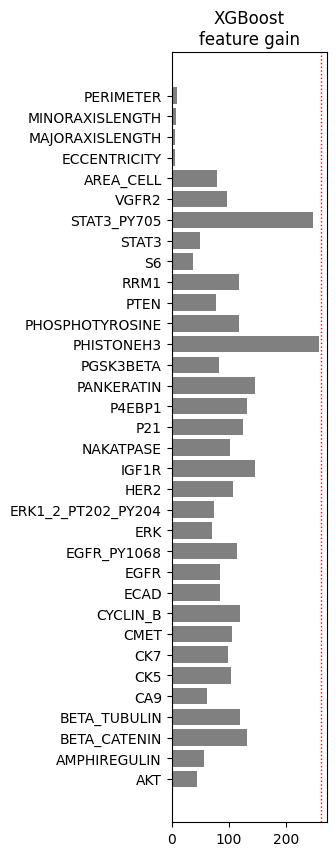

In [231]:

import matplotlib.pyplot as plt
plt.figure(figsize=(2, 10))


# b = xg.feature_importances_
b = xg.get_booster().get_score(importance_type="gain").values()
# b = xg.get_booster().get_score(importance_type="weight").values()


# mask0 = b <= 0
# mask1 = b > 0
# feats0 = [all_feats[i] for i, x in enumerate(mask0) if x == True]
# feats1 = [all_feats[i] for i, x in enumerate(mask1) if x == True]

# plt.barh(feats0, b[mask0], color='blue')
# plt.barh(feats1, b[mask1], color='black')
plt.barh(all_feats, b, color="gray")
plt.axvline(x=260, color='red', linewidth=1, linestyle=':')


# plt.barh(all_feats, b, color="k")
plt.title("XGBoost\nfeature gain")
plt.show()

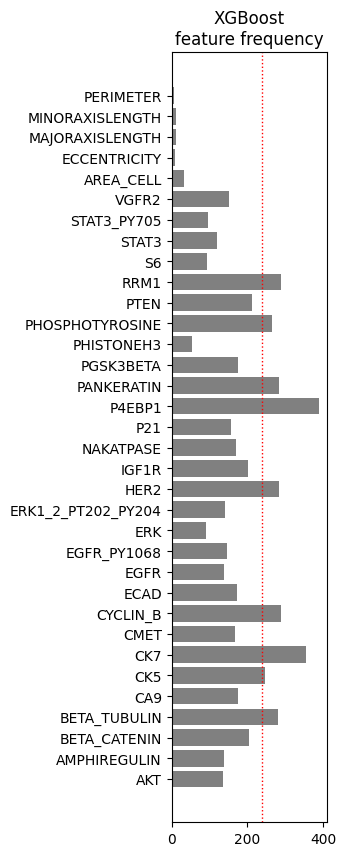

In [232]:

import matplotlib.pyplot as plt
plt.figure(figsize=(2, 10))


# b = xg.feature_importances_
b = xg.get_booster().get_score(importance_type="weight").values()
# b = xg.get_booster().get_score(importance_type="weight").values()


# mask0 = b <= 0
# mask1 = b > 0
# feats0 = [all_feats[i] for i, x in enumerate(mask0) if x == True]
# feats1 = [all_feats[i] for i, x in enumerate(mask1) if x == True]

# plt.barh(feats0, b[mask0], color='blue')
# plt.barh(feats1, b[mask1], color='black')
plt.barh(all_feats, b, color="gray")
plt.axvline(x=238, color='red', linewidth=1, linestyle=':')


# plt.barh(all_feats, b, color="k")
plt.title("XGBoost\nfeature frequency")
plt.show()

In [100]:
# from sklearn.ensemble import GradientBoostingClassifier
# gbc = GradientBoostingClassifier(n_estimators=100, random_state=0).fit(X, y)

In [101]:
# print(gbc.score(X, y))
# print(gbc.score(Xt, yt))

# print(gbc.feature_importances_)


In [102]:
# fpr, tpr, thresholds = metrics.roc_curve(yt, gbc.predict_proba(Xt)[:,1])
# metrics.auc(fpr, tpr)

In [103]:
# # plot the roc curve for the model
# plt.figure()
# plt.plot(fpr, tpr, label='XGBoost')
# # axis labels
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# # show the legend
# plt.legend()
# plt.show()

In [104]:
# plt.barh(all_feats, gbc.feature_importances_)

# import matplotlib.pyplot as plt
# plt.figure(figsize=(3, 10))


# b = gbc.feature_importances_
# # mask0 = b <= 0
# # mask1 = b > 0
# # feats0 = [all_feats[i] for i, x in enumerate(mask0) if x == True]
# # feats1 = [all_feats[i] for i, x in enumerate(mask1) if x == True]

# # plt.barh(feats0, b[mask0], color='blue')
# # plt.barh(feats1, b[mask1], color='black')
# plt.barh(all_feats, b, color="k")


# # plt.barh(all_feats, b, color="k")
# plt.title("XGBoost feature importance")
# plt.show()

In [105]:
# features = [0, 1, (0, 1)]
# PartialDependenceDisplay.from_estimator(clf, X, features)


## Try MLP

In [233]:
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(random_state=1, max_iter=10000)

In [234]:
nn.fit(X, y)

MLPClassifier(max_iter=10000, random_state=1)

In [235]:
nn.score(Xt, yt)

0.954726443768997

In [236]:
nn.score(X, y)

0.959198018222023

In [237]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(yt, nn.predict_proba(Xt)[:,1])
metrics.auc(fpr, tpr)

0.9884979177385215

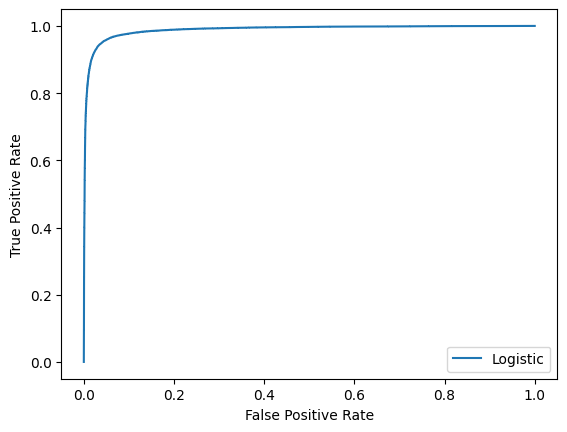

In [238]:
# plot the roc curve for the model
plt.figure()
plt.plot(fpr, tpr, label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.show()

In [239]:
metrics.balanced_accuracy_score(yt, nn.predict(Xt))

0.9546956366185525

In [240]:
# import shap
# explainer = shap.KernelExplainer(nn.predict, data=shap.sample(X,100), feature_names=all_feats)
# shap_values = explainer(X[:1000,:])

In [241]:
# shap_values.shape

In [242]:
# shap.plots.bar(shap_values)

In [243]:
# # plt.barh(all_feats, np.abs(shap_values.values).mean(0))

# import matplotlib.pyplot as plt
# plt.figure(figsize=(2, 10))


# b = np.abs(shap_values.values).mean(0)
# # mask0 = b <= 0
# # mask1 = b > 0
# # feats0 = [all_feats[i] for i, x in enumerate(mask0) if x == True]
# # feats1 = [all_feats[i] for i, x in enumerate(mask1) if x == True]

# # plt.barh(feats0, b[mask0], color='blue')
# # plt.barh(feats1, b[mask1], color='black')
# plt.barh(all_feats, np.abs(shap_values.values).mean(0), color="gray")
# plt.axvline(x=0.036427, color='red', linewidth=1, linestyle=':')
# # plt.barh(all_feats, b, color="k")
# plt.title("MLP\nShapley values")
# plt.show()

In [244]:
# shap.plots.scatter(shap_values, ylabel="SHAP value\n(higher means more likely to renew)")


ElasticNet
Training score: 0.7145647003396682 0.7145647003396682
Subset score: 0.7130547112462006 0.7130547112462006
Training auc: 0.779946752083371
Subset auc: 0.782154059172203

XGBoost
Training score: 0.9707634556493591 0.9707634556493591
Subset score: 0.9611702127659575 0.9611702127659575
Training auc: 0.9925512772569732
Subset auc: 0.9958391200343689

MLP
Training score: 0.959198018222023 0.959198018222023
Subset score: 0.954726443768997 0.954726443768997
Training auc: 0.9884979177385215
Subset auc: 0.9908803919259614



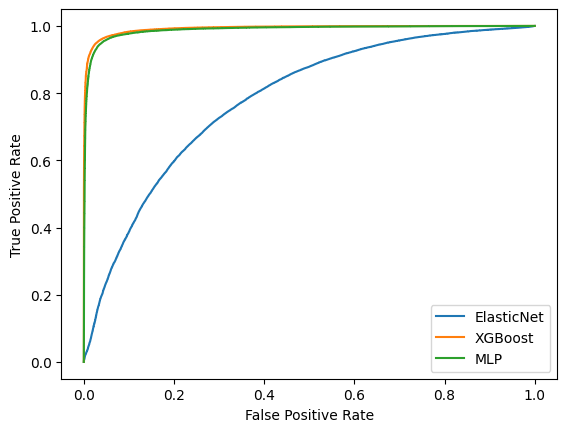

In [245]:
plt.figure()
labs = ["ElasticNet", "XGBoost", "MLP"]
for i, classifier in enumerate([clf_all, xg, nn]):
    y_pred = classifier.predict(X)
    y_prob = classifier.predict_proba(X)[:,1]
    y_predt = classifier.predict(Xt)
    y_probt = classifier.predict_proba(Xt)[:,1]
    
    score = accuracy_score(y, y_pred)
    scoret = accuracy_score(yt, y_predt)
    
    fpr, tpr, thresholds = metrics.roc_curve(y, y_prob)
    auc = metrics.auc(fpr, tpr)
    
    fpr, tpr, thresholds = metrics.roc_curve(yt, y_probt)
    auct = metrics.auc(fpr, tpr)
    
    print(labs[i])
    print("Training score:", classifier.score(X, y), score)
    print("Subset score:", classifier.score(Xt, yt), scoret)
    print("Training auc:", auct)
    print("Subset auc:", auc)
    print()
    plt.plot(fpr, tpr, label=labs[i])


# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
    
# show the legend
plt.legend()
plt.show()

In [267]:
serialize(clf_all, "/scr/biggest/gmachi/datasets/celldive_lung/top_model_results_final/elasticnet_all.model")
serialize(clf, "/scr/biggest/gmachi/datasets/celldive_lung/top_model_results_final/elasticnet_ovr.model")
serialize(nn, "/scr/biggest/gmachi/datasets/celldive_lung/top_model_results_final/mlp.model")
serialize(xg, "/scr/biggest/gmachi/datasets/celldive_lung/top_model_results_final/xgb.model")

## Ranked importances

In [607]:
b = np.abs(shap_values.values).mean(0)
vals = dict(zip(all_feats, b))
sorted(vals.items(), key=lambda x: x[1], reverse=True)


[('PANKERATIN', 0.06763494701111156),
 ('ERK', 0.06619372411547199),
 ('ERK1_2_PT202_PY204', 0.06268465046443415),
 ('PHOSPHOTYROSINE', 0.06140518376607049),
 ('CK7', 0.050512085371051875),
 ('P4EBP1', 0.04504883541661655),
 ('BETA_TUBULIN', 0.042672620112445304),
 ('EGFR_PY1068', 0.037442430756127215),
 ('P21', 0.037299226727438614),
 ('CK5', 0.036427114601221965),
 ('STAT3_PY705', 0.035540956545354704),
 ('PTEN', 0.03377113677918395),
 ('STAT3', 0.03357370341746178),
 ('CYCLIN_B', 0.03122854187987201),
 ('AMPHIREGULIN', 0.03078395883514001),
 ('CMET', 0.030775841585625963),
 ('RRM1', 0.029464411839870263),
 ('PGSK3BETA', 0.02838506081205425),
 ('HER2', 0.027328247137869636),
 ('AKT', 0.02703959601222384),
 ('ECAD', 0.026235758915382754),
 ('EGFR', 0.025544538729400008),
 ('IGF1R', 0.025306999399679262),
 ('BETA_CATENIN', 0.022768954094744807),
 ('NAKATPASE', 0.022703940859617956),
 ('PERIMETER', 0.021439343327611052),
 ('S6', 0.021214244656080357),
 ('CA9', 0.02067171774045274),
 ('P

In [600]:
# print(xg.get_booster().get_score(importance_type="weight"))
# print(xg.get_booster().get_score(importance_type="weight").keys())
b = xg.get_booster().get_score(importance_type="gain").values()
# print(b)
vals = dict(zip(all_feats, b))
sorted(vals.items(), key=lambda x: x[1], reverse=True)


[('PHISTONEH3', 415.1111755371094),
 ('ECAD', 317.6909484863281),
 ('STAT3_PY705', 307.5013122558594),
 ('IGF1R', 289.44036865234375),
 ('CYCLIN_B', 289.0143737792969),
 ('PHOSPHOTYROSINE', 266.583251953125),
 ('P4EBP1', 265.6700134277344),
 ('CK5', 264.4093322753906),
 ('PANKERATIN', 263.4822692871094),
 ('HER2', 262.51385498046875),
 ('EGFR_PY1068', 257.23822021484375),
 ('P21', 253.95278930664062),
 ('AREA_CELL', 250.98939514160156),
 ('CK7', 246.45985412597656),
 ('BETA_TUBULIN', 240.18124389648438),
 ('VGFR2', 234.13047790527344),
 ('RRM1', 224.6455841064453),
 ('PTEN', 218.48118591308594),
 ('CA9', 217.2509765625),
 ('ERK1_2_PT202_PY204', 212.64816284179688),
 ('PGSK3BETA', 210.91725158691406),
 ('STAT3', 186.13671875),
 ('BETA_CATENIN', 184.42208862304688),
 ('NAKATPASE', 172.2122344970703),
 ('CMET', 166.76290893554688),
 ('AMPHIREGULIN', 150.8935546875),
 ('AKT', 147.22865295410156),
 ('ERK', 136.35350036621094),
 ('EGFR', 134.2201385498047),
 ('S6', 77.5842056274414),
 ('MINO

In [601]:
# print(xg.get_booster().get_score(importance_type="weight"))
# print(xg.get_booster().get_score(importance_type="weight").keys())
b = xg.get_booster().get_score(importance_type="weight").values()
# print(b)
vals = dict(zip(all_feats, b))
sorted(vals.items(), key=lambda x: x[1], reverse=True)

[('P4EBP1', 414.0),
 ('CK7', 347.0),
 ('CYCLIN_B', 324.0),
 ('PHOSPHOTYROSINE', 308.0),
 ('BETA_TUBULIN', 307.0),
 ('RRM1', 296.0),
 ('HER2', 286.0),
 ('CK5', 272.0),
 ('PANKERATIN', 269.0),
 ('BETA_CATENIN', 245.0),
 ('P21', 233.0),
 ('PGSK3BETA', 221.0),
 ('PTEN', 197.0),
 ('ERK1_2_PT202_PY204', 182.0),
 ('VGFR2', 181.0),
 ('CMET', 180.0),
 ('IGF1R', 178.0),
 ('NAKATPASE', 173.0),
 ('ECAD', 163.0),
 ('AKT', 157.0),
 ('EGFR_PY1068', 155.0),
 ('CA9', 147.0),
 ('AMPHIREGULIN', 134.0),
 ('STAT3', 129.0),
 ('EGFR', 120.0),
 ('S6', 112.0),
 ('ERK', 110.0),
 ('STAT3_PY705', 90.0),
 ('PHISTONEH3', 73.0),
 ('MINORAXISLENGTH', 16.0),
 ('AREA_CELL', 15.0),
 ('MAJORAXISLENGTH', 8.0),
 ('PERIMETER', 5.0),
 ('ECCENTRICITY', 4.0)]